In [1]:
import pandas as pd
import numpy as np
import re
from setuptools.build_meta import prepare_metadata_for_build_editable
from tensorflow import config, device
from tensorflow.keras import utils, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Dense, Bidirectional, Dropout
from tensorflow.keras.regularizers import l1_l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
gpus = config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        config.experimental.set_visible_devices(gpus[0], 'GPU')
        config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
def loss_plot(history_):
    loss     = history_.history['loss']
    val_loss = history_.history['val_loss']
    epochs   = range(len(loss))
    plt.figure()
    plt.plot  ( epochs,loss )
    plt.plot  ( epochs,val_loss )
    plt.title ('Training and validation loss')
def acc_plot(history_):
    acc = history_.history['accuracy']
    val_acc  = history_.history[ 'val_accuracy' ]
    epochs   = range(len(acc))
    plt.figure()
    plt.plot  ( epochs,     acc )
    plt.plot  ( epochs, val_acc )
    plt.title ('Training and validation accuracy')


In [2]:
text = open('shakespeare.txt', 'rb').read().decode(encoding='utf-8')
text = re.sub(r'\n+', ' ', text)
text = re.sub(r'[^\w\s.,!?;]', '', text)
sentences = re.split(r'[.!?;]', text)
sentences = [s.strip() for s in sentences if s.strip()]

In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
vocab_size = len(tokenizer.word_index) + 1
input_sequences = []

for line in sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
max_sequence_len = 20
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='post'))
xs, labels = input_sequences[:, :-1], input_sequences[:, -1]
ys = utils.to_categorical(labels, num_classes=vocab_size)
x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, random_state=42)

In [11]:
model = Sequential([
    Embedding(vocab_size, 100, input_length=max_sequence_len-1),
    LSTM(150, return_sequences=False),
    Dense(vocab_size, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
with device('/cpu:0'):
    model.fit(xs, ys, epochs=50, batch_size=32)


In [8]:
model = Sequential([
    Embedding(vocab_size, 50, input_length=max_sequence_len-1),
    Bidirectional(LSTM(50, activity_regularizer=l1_l2(l1=0.01, l2=0.01))),
    Dropout(0.2),
    Dense(vocab_size, activation='softmax')
])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2, min_lr=1e-6)
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
with device('/cpu:0'):
    history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler], 
                        batch_size=128, verbose=2)

Epoch 1/50
594/594 - 22s - loss: 5.4504 - accuracy: 0.7898 - val_loss: 3.1171 - val_accuracy: 0.8057 - lr: 1.0000e-04 - 22s/epoch - 37ms/step
Epoch 2/50
594/594 - 18s - loss: 2.8257 - accuracy: 0.8093 - val_loss: 2.6771 - val_accuracy: 0.8057 - lr: 1.0000e-04 - 18s/epoch - 31ms/step
Epoch 3/50
594/594 - 18s - loss: 2.4914 - accuracy: 0.8093 - val_loss: 2.4438 - val_accuracy: 0.8057 - lr: 1.0000e-04 - 18s/epoch - 31ms/step
Epoch 4/50
594/594 - 17s - loss: 2.2852 - accuracy: 0.8093 - val_loss: 2.2874 - val_accuracy: 0.8057 - lr: 1.0000e-04 - 17s/epoch - 29ms/step
Epoch 5/50
594/594 - 17s - loss: 2.1378 - accuracy: 0.8093 - val_loss: 2.1731 - val_accuracy: 0.8057 - lr: 1.0000e-04 - 17s/epoch - 29ms/step
Epoch 6/50
594/594 - 20s - loss: 2.0283 - accuracy: 0.8093 - val_loss: 2.0885 - val_accuracy: 0.8057 - lr: 1.0000e-04 - 20s/epoch - 33ms/step
Epoch 7/50
594/594 - 18s - loss: 1.9427 - accuracy: 0.8093 - val_loss: 2.0248 - val_accuracy: 0.8057 - lr: 1.0000e-04 - 18s/epoch - 30ms/step
Epoch 

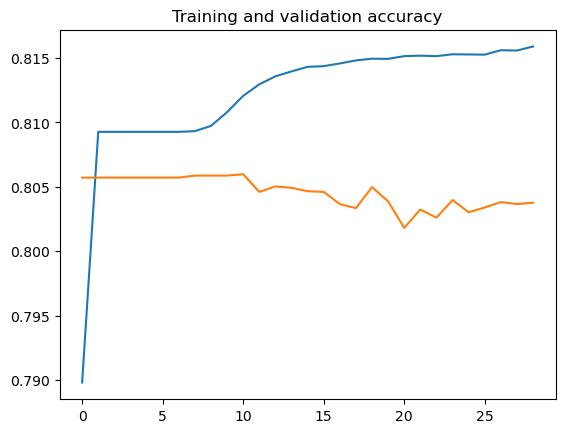

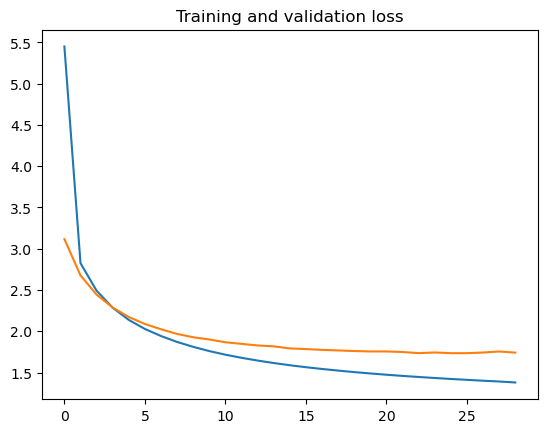

In [9]:
acc_plot(history)
loss_plot(history)

Epoch 1/50
1187/1187 - 28s - loss: 4.1006 - accuracy: 0.8004 - val_loss: 2.6495 - val_accuracy: 0.8057 - lr: 1.0000e-04 - 28s/epoch - 23ms/step
Epoch 2/50
1187/1187 - 23s - loss: 2.3764 - accuracy: 0.8093 - val_loss: 2.2668 - val_accuracy: 0.8057 - lr: 1.0000e-04 - 23s/epoch - 19ms/step
Epoch 3/50
1187/1187 - 24s - loss: 2.0814 - accuracy: 0.8093 - val_loss: 2.0788 - val_accuracy: 0.8057 - lr: 1.0000e-04 - 24s/epoch - 20ms/step
Epoch 4/50
1187/1187 - 24s - loss: 1.9119 - accuracy: 0.8093 - val_loss: 1.9614 - val_accuracy: 0.8057 - lr: 1.0000e-04 - 24s/epoch - 20ms/step
Epoch 5/50
1187/1187 - 24s - loss: 1.7975 - accuracy: 0.8093 - val_loss: 1.8903 - val_accuracy: 0.8057 - lr: 1.0000e-04 - 24s/epoch - 20ms/step
Epoch 6/50
1187/1187 - 24s - loss: 1.7103 - accuracy: 0.8104 - val_loss: 1.8325 - val_accuracy: 0.8064 - lr: 1.0000e-04 - 24s/epoch - 20ms/step
Epoch 7/50
1187/1187 - 24s - loss: 1.6459 - accuracy: 0.8120 - val_loss: 1.8040 - val_accuracy: 0.8057 - lr: 1.0000e-04 - 24s/epoch - 20

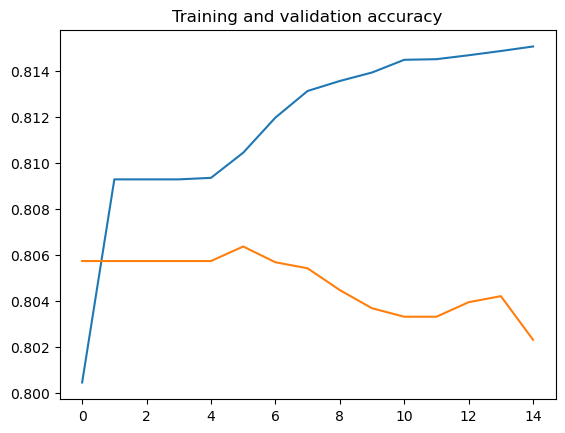

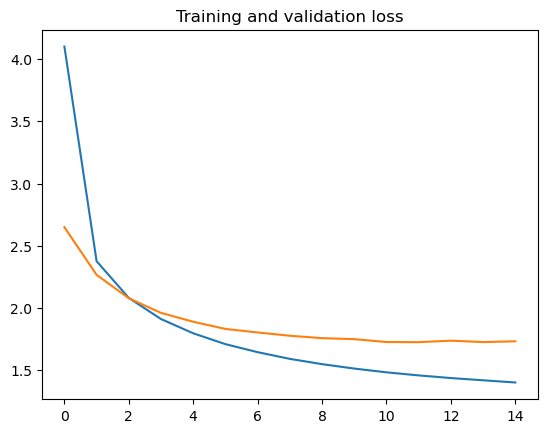

In [4]:
model = Sequential([
    Embedding(vocab_size, 50, input_length=max_sequence_len-1),
    Bidirectional(LSTM(50, activity_regularizer=l1_l2(l1=0.01, l2=0.01))),
    Dropout(0.2),
    Dense(vocab_size, activation='softmax')
])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2, min_lr=1e-6)
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
with device('/cpu:0'):
    history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler], 
                        batch_size=64, verbose=2)
acc_plot(history)
loss_plot(history)

In [5]:
model.save('text_model.keras')

In [6]:
model.load_weights('text_model.keras')

In [21]:
seed_text = "Before we proceed"
next_words = 10
generated_text = seed_text

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([generated_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='post')
    probabilities = model.predict(token_list, verbose=0)[0]
    probabilities[0] = 0
    probabilities = probabilities / probabilities.sum()
    predicted = np.random.choice(len(probabilities), p=probabilities)
    if predicted != 0:
        output_word = tokenizer.index_word[predicted]
        generated_text += " " + output_word

print("Generated Text:")
print(generated_text)


Generated Text:
Before we proceed least candles high spread free withdraw somebody enjoy inauspicious darkness
